# Friday, November 10th, 2017
[Joshua Marshall Moore](thwee.abacadabra.alchemist@gmail.com)

This is an example of genetic programming, as presented by http://burakkanber.com/blog/machine-learning-genetic-algorithms-part-1-javascript/.

In [1]:
import random
from math import floor
import matplotlib.pyplot as plt

The Gene class is responsible for carrying "genetic" information, i.e. a string. 
* A call to mutate with a given rate results in either no change, or a change to a single character in the genomic code. 
* A call to random chooses random characters of number length as the Gene's code.
* A call to calc_cost compares this Gene's genome with a target string, assigning itself the cost in the process. 
* mate takes another Gene as an argument and returns two genes sharing half their parents' code. 

In [48]:
class Gene():
    def __init__(self, code):
        self.code = code
        self.cost = 9999

    def mate(self, gene):
        middle = int(floor(len(self.code)/2))
        return [Gene(self.code[:middle] + gene.code[middle:]),
                Gene(gene.code[:middle] + self.code[middle:])]

    def mutate(self, rate):
        if random.random() < rate:
            return

        code = ''
        index = round(random.random() * len(self.code))
        for i in range(len(self.code)):
            upOrDown = -1 if round(random.random()) else 1
            if i == index and ord(self.code[i]) + upOrDown < 256 and ord(self.code[i]) > 0:
                code += chr(ord(self.code[i]) + upOrDown)
            else:
                code += self.code[i]

        self.code = code

    def random(self, length):
        code = ''
        for i in range(length):
            code += chr(int(random.random()*255))
        self.code = code

    def calc_cost(self, target):
        total = 0
        
        for i in range(len(self.code)):
            total += (ord(self.code[i]) - ord(target[i])) * (ord(self.code[i]) - ord(target[i]))

        self.cost = total

A population, in this context serves to evolve the genes to a predermined string. 
* `__init__` takes the target string, the population size, the chance of mutation per gene and round, and a boolean indicating whether to log the calculated costs each iteration.
* `calc_costs` calculates the costs of all of its member genes as compared to the target string.
* mutate takes chance as a parameter mutates all genes with the same chance of mutation. 
* `_generation` calls mutate and calc_costs and mates the Genes, returning True if the target string has been reached, and False otherwise. 
* `genotype` calls `_generation` until the target string has been reached. 

In [58]:
class Population():
    def __init__(self, target="Hello, Worlds!", size=100, log_costs=False):
        self.target = target
        self.members = []
        for i in range(size):
            gene = Gene('')
            gene.random(len(self.target))
            self.members.append(gene)
        self.generationNumber = 0
        
        self.log_costs = log_costs
        if self.log_costs:
            self.cost_log = [] # logs the cost of the highest ranking member
        
    def calc_costs(self):
        for member in self.members:
            member.calc_cost(self.target)

    def mutate(self, chance):
        for member in self.members:
            member.mutate(chance)

    # Should be called after Population.calcCosts()
    def sort(self):
        self.members = sorted(self.members, key=lambda member: member.cost)

    def display(self):
        self.calcCosts()
        self.sort()
        print("Generation", self.generationNumber, self.members[0].code, self.members[0].cost)

    def genotype(self, mutation_rate=0.5, display=False):
        while not self._generation(mutation_rate, display):
            pass
            
        if self.log_costs:
            return self.cost_log
        else:
            return self.generationNumber
        
    def _generation(self, mutation_rate=0.5, display=False):
        self.calc_costs()
        self.sort()
        if self.log_costs:
            self.cost_log.append(self.members[0].cost)
        if display:
            self.display()

        children = self.members[0].mate(self.members[1])
        self.members[-2] = children[0]
        self.members[-1] = children[1]

        for member in self.members:
            member.mutate(mutation_rate)
            member.calc_cost(self.target)
            if member.code == self.target:
                self.sort()
                if display:
                    self.display()
                return True

        self.generationNumber += 1
        return False
    

Now we can manipulate variables and see what happens. 

0.0 6261499
0.05 12054297
0.1 8419884
0.15 8547326
0.2 10512502
0.25 10998449
0.3 11674858
0.35 11414674
0.4 9119747
0.45 15808637
0.5 8550402
0.55 9175902
0.6 22539258
0.65 15047852
0.7 21657241
0.75 21217612
0.8 14227381
0.85 10418546
0.9 25787970
0.95 30498378


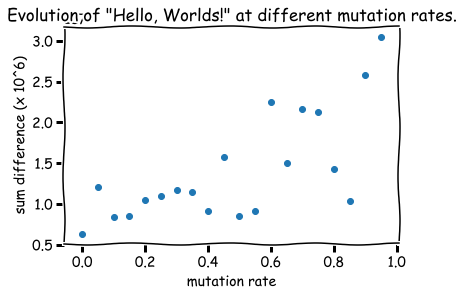

In [72]:
import numpy as np
import matplotlib.pyplot as plt

plt.ion()
plt.xkcd()
plt.title('Evolution of "Hello, Worlds!" at different mutation rates.')
plt.xlabel('mutation rate')
plt.ylabel('sum difference (x 10^6)')

def genotype(mutation_rate):
    population = Population(log_costs=True)
    population.genotype(mutation_rate=pct)
    s = sum(population.cost_log)
    print(mutation_rate, s)
    return s
    
population = Population(log_costs=True)
plt.scatter(np.arange(0.0, 1.0, 0.05), [genotype(pct) for pct in np.arange(0.0, 1.0, 0.05)])
plt.show()


That doesn't look right! How can the sum of the population cost log be 3.5 at maximum? Time to adjust the legend. 

In [ ]:
plt.ion()
plt.xkcd()
plt.title('Evolution of "Hello, Worlds!" at different population sizes')
plt.xlabel('population size')
plt.ylabel('sum difference')

def genotype(population_size=100):
    population = Population("Hello, Worlds!", size=population_size, log_costs=True)
    population.genotype(mutation_rate=0.1)
    s = sum(population.cost_log)
    print(population_size, s)
    return s

plt.scatter(range(10, 250, 10), [genotype(pop_size) for pop_size in range(10, 250, 10)])
plt.show()

10 20152036
20 7481258
30 10991829
40 11387671
50 6682291
60 5591104
70 17970466
80 5914454
90 9997164
100 4616783
110 6645520


Time to learn basic plotting...

In [ ]:
plt.ion()
plt.xkcd()
data = [[0],[0]]
plt.scatter([1], [0])
plt.show()

Now I can go back up and scatter my population cost data